# Deep learning Keras-based solution of the MNIST problem

## 1. Load data

In [1]:
# Todo add K-fold
# Todo choose the best params and cnn architecture
# Todo add a pipeline to scale params
# Todo implement augmentation?
# Todo try to get a pretrained cnn

In [2]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv('../data/train.csv.zip')
args.raw_test = pd.read_csv('../data/test.csv.zip')
args.predictions_folder = Path('../predictions')

args.n_splits = 10
args.n_jobs = -1
args.val_fraction = 0.1
args.epochs = 50
args.model_name = 'deep-learning-keras-model.hdf5'

args.train = args.raw_train.iloc[:, 1:].copy()
args.labels = args.raw_train['label'].copy()
args.test = args.raw_test.copy()

args.run_baseline = False
args.run_early_stop = False
args.run_kfold = True

args.predictions_folder.mkdir(parents=True, exist_ok=True) 

In [4]:
args.raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
args.raw_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
args.raw_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [7]:
def plot_number(label, pixels_2d, size_inches=None):
    title = args.raw_train.iloc[random_row, 0]
    fig, ax = plt.subplots()
    if size_inches:
        fig.set_size_inches(size_inches[0], size_inches[1])
    ax.set_title(label)
    imgplot = ax.imshow(pixels_2d)

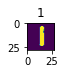

In [8]:
# Matlbab state-based style of image rendering 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
plot_number(label, pixels_2d, (0.5, 0.5))

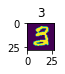

In [9]:
# OO-style image rendering
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_row = random.randrange(0, args.raw_train.shape[0], 1)
label = args.raw_train.iloc[random_row, 0]
pixels_2d = args.raw_train.iloc[random_row, 1:].to_numpy().reshape(28, 28)
plot_number(label, pixels_2d, (0.5, 0.5))

## 2. Training

In [10]:
import sklearn.utils.multiclass

X = args.train.to_numpy().reshape(args.train.shape[0], 28, 28, 1)
y = pd.get_dummies(args.labels, prefix='label').to_numpy()
y_sparse = args.labels.to_numpy()
x = args.test.to_numpy().reshape(args.test.shape[0], 28, 28, 1)

log.info('X.shape: %s', repr(X.shape))
log.info('X[0][14][14]: %s', X[0][14][14])

log.info('y.shape: %s', repr(y.shape))
log.info('y[0], %s', y[0])
log.info('type of target y: %s', repr(sklearn.utils.multiclass.type_of_target(y)))

log.info('y_sparse.shape: %s', repr(y_sparse.shape))
log.info('y_sparse: %s', repr(y_sparse))
log.info('y_sparse[0]: %s', y_sparse[0])
log.info('type of target y_sparse: %s', repr(sklearn.utils.multiclass.type_of_target(y_sparse)))

2020-04-29 19:38:08,107 : INFO : X.shape: (42000, 28, 28, 1)
2020-04-29 19:38:08,108 : INFO : X[0][14][14]: [254]
2020-04-29 19:38:08,109 : INFO : y.shape: (42000, 10)
2020-04-29 19:38:08,109 : INFO : y[0], [0 1 0 0 0 0 0 0 0 0]
2020-04-29 19:38:08,115 : INFO : type of target y: 'multilabel-indicator'
2020-04-29 19:38:08,115 : INFO : y_sparse.shape: (42000,)
2020-04-29 19:38:08,116 : INFO : y_sparse: array([1, 0, 1, ..., 7, 6, 9])
2020-04-29 19:38:08,116 : INFO : y_sparse[0]: 1
2020-04-29 19:38:08,118 : INFO : type of target y_sparse: 'multiclass'


In [11]:
# Deprecated?
def predict(X, y, x, build_classifier, parameters, splits=args.n_splits, n_jobs=args.n_jobs):
    skf = StratifiedKFold(n_splits=splits, shuffle=True)
    classifier = build_classifier()
    gcv = GridSearchCV(classifier, parameters, n_jobs=n_jobs, cv=skf, verbose=5)
    gcv.fit(X, y)
    log.info('Best params: %s', repr(gcv.best_params_))
    log.info('Best CV score: %s', repr(gcv.best_score_))
    log.info('Best std: %s', repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    classifier = build_classifier(gcv.best_params_)
    classifier.fit(X, y)
    predictions = classifier.predict(x)
    return gcv.best_params_, gcv.best_score_, predictions.astype(int)

In [12]:
def csv_sparse_predictions(predictions_sparse, filename):
    image_ids = np.arange(1, len(predictions_sparse) + 1)
    submission = pd.DataFrame({'ImageId': image_ids, 'Label': predictions_sparse})
    filepath = args.predictions_folder/filename
    
    submission.to_csv(filepath, index=False)
    log.info('Saved file: %s', filepath)

In [13]:
def csv_predictions(predictions, filename):
    log.debug('predictions.shape: %s', repr(predictions.shape))
    predictions_sparse = np.argmax(predictions, axis=1)
    csv_sparse_predictions(predictions_sparse, filename)

In [14]:
def plot_history(history):
    log.info("History keys: %s", history.history.keys())
    # Accuracy
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history.history['sparse_categorical_accuracy'], label='Train')
    ax.plot(history.history['val_sparse_categorical_accuracy'], label='Test')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend(['Train', 'Test'], loc='lower right')
    
    # Loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.grid()
    plt.show()


In [15]:
from keras import models

def build_model(layers_list, optimizer='rmsprop',
                loss='sparse_categorical_crossentropy', metrics_tuple=('sparse_categorical_accuracy')):
    model = models.Sequential(layers_list)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metrics_tuple])
    log.info(model.summary())
    return model

Using TensorFlow backend.


### 2.1 Baseline

In [16]:
from keras import layers 

def build_baseline_model_sparse():
    layers_list = [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ]
    return build_model(layers_list=layers_list)

In [17]:
%%time

def baseline():
    model = build_baseline_model_sparse()
    history = model.fit(X, y_sparse, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1)
    plot_history(history)
    predictions = model.predict(x)
    csv_predictions(predictions, 'cnn_baseline_predictions.csv')
    
if args.run_baseline:
    baseline()

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 7.87 µs


### 2.2 Early stop

In [18]:
%%time

from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def early_stop(monitor='val_loss'):
    # val_loss
    # val_accuracy
    early_stopping = EarlyStopping(monitor=monitor, patience=10, mode='auto', verbose=1)
    model_checkpoint = ModelCheckpoint(args.model_name, save_best_only=True, monitor=monitor, mode='auto', verbose=1)
    reduce_lr_on_plateau = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='auto')

    model = build_baseline_model_sparse()
    history = model.fit(X, y_sparse, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau])

    plot_history(history)
    model.load_weights(args.model_name)
    predictions = model.predict(x)
    csv_predictions(predictions, 'cnn_early_stop_predictions.csv')

if args.run_baseline:
    early_stop(monitor='val_sparse_categorical_accuracy')

CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 15.3 µs


### 2.3 K-Fold validation to choose the best architecture

In [22]:
%%time 

from keras import layers 
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def kfold():
    layers_candidates = {
        1: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')],

#         2: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(128, (3, 3), activation='relu'),
#         layers.Flatten(),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(10, activation='softmax')],

#         3: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.Flatten(),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(10, activation='softmax')],

#         4: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#         layers.Flatten(),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(10, activation='softmax')],
    }
    
    def _build_model_kfold(layers_candidates_key=1):
        return build_model(layers_candidates[layers_candidates_key])
    
    keras_classifier = KerasClassifier(_build_model_kfold, 
                                       layers_candidates_key=1)
    gcv = GridSearchCV(keras_classifier,
                         param_grid={'epochs': [30], 
                                     'layers_candidates_key': list(layers_candidates.keys())},
                         cv=args.n_splits,
                         scoring='accuracy',
                         n_jobs=args.n_jobs,
                         verbose=2)
    gcv.fit(X, y_sparse)
    log.info('Best params: %s', repr(gcv.best_params_))
    log.info('Best CV score: %s', repr(gcv.best_score_))
    log.info('Best std: %s', repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    
if args.run_kfold:
    kfold()

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 12.1min remaining: 12.1min


KeyboardInterrupt: 

#### 2.3.1 Results

input:
{'epochs': [2, 3, 4, 5, 6, 7, 8, 9, 10], 
                                     'layers_candidates_key': list(layers_candidates.keys()), 
                                     'metrics_tuple': [('sparse_categorical_accuracy'), ('loss')]},
results:

2020-04-26 15:34:19,980 : INFO : Best params: {'epochs': 10, 'layers_candidates_key': 1, 'metrics_tuple': 'sparse_categorical_accuracy'}
2020-04-26 15:34:19,982 : INFO : Best CV score: 0.9835238095238095
2020-04-26 15:34:19,983 : INFO : Best std: 0.001621147098147533   

---
input:
 param_grid={'epochs': [10, 20, 30], 
                                     'layers_candidates_key': list(layers_candidates.keys()), 
                                     'metrics_tuple': [('sparse_categorical_accuracy'), ('loss')]},
                         cv=args.n_splits,
                         scoring='accuracy'}


2020-04-27 23:44:34,829 : INFO : Best params: {'epochs': 30, 'layers_candidates_key': 1, 'metrics_tuple': 'sparse_categorical_accuracy'}
2020-04-27 23:44:34,829 : INFO : Best CV score: 0.9846190476190475
2020-04-27 23:44:34,830 : INFO : Best std: 0.002779092659317115

In [20]:
assert False

AssertionError: 

In [ ]:
from keras import layers 

keras_classifier = KerasClassifier(build_model, layers_candidates_key=1, metrics_tuple=('sparse_categorical_accuracy'))
gcv = GridSearchCV(keras_classifier,
#                          param_grid={'epochs': [2, 3, 4, 5, 7, 10, 15], 'layers_candidates_key': list(layers_candidates.keys())},
                         param_grid={'epochs': [2], 'layers_candidates_key': list(layers_candidates.keys())},
                         cv=5,
                         scoring='accuracy',
                         n_jobs=-1,
                         verbose=5)
gcv.fit(X, y)
# keras_classifier.fit(X, y)
log.info('Best params: %s', repr(gcv.best_params_))
log.info('Best CV score: %s', repr(gcv.best_score_))
log.info('Best std: %s', repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))

In [ ]:
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# val_loss
# val_accuracy
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3, mode='auto', verbose=1)
model_checkpoint = ModelCheckpoint(args.model_name, save_best_only=True, monitor='val_sparse_categorical_accuracy', mode='auto', verbose=1)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='auto')

model = build_baseline_model_sparse()
model.fit(X, y1, validation_split=args.val_fraction, epochs=args.epochs, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau])

In [ ]:
# predict
model.load_weights(args.model_name)
predictions = model.predict(x)
log.info('predictions.shape: %s', repr(predictions.shape))
predictions_sparse = np.argmax(predictions, axis=1)

csv_sparse_predictions(predictions_sparse, 'cnn_predictions.csv')

## 3. Results' analysis

In [ ]:
# analysis of the most confusing predicitons
def analyse_confusing_predictions(predictions=predictions, n_confused=10, labels=None):
    log.info(predictions.shape)
    probabilities_sparse = np.max(predictions, axis=1)
    min_prob = np.min(probabilities_sparse)
    min_index = np.argmin(probabilities_sparse, axis=0)
    log.info('The most likely numbers for the less confident prediction: %s, probabilities: %s', 
             np.argpartition(predictions[min_index], -3)[-3:], 
             predictions[min_index][np.argpartition(predictions[min_index], -3)[-3:]])
    
    most_confused_predictions_indices = np.argpartition(probabilities_sparse, n_confused)[:n_confused]
    log.info('Most confused indices: %s', most_confused_predictions_indices)
    most_confused_probabilities = predictions[most_confused_predictions_indices]
    likely_numbers_most_confused_probabilities = np.argpartition(most_confused_probabilities, -3, axis=1)[:, -3:]

    probabilities_likely_numbers_most_confused_probabilities = np.empty(likely_numbers_most_confused_probabilities.shape)
    for i, row in enumerate(most_confused_probabilities):
        probabilities_likely_numbers_most_confused_probabilities[i] = row[likely_numbers_most_confused_probabilities[i]]

    log.info('The most likely numbers for the less confident predictions: \n%s, \nprobabilities: \n%s', 
            likely_numbers_most_confused_probabilities,
            np.around(probabilities_likely_numbers_most_confused_probabilities, decimals=2))

    if labels is not None:
        for most_confusing_predictions_index in most_confused_predictions_indices:
            draw_number(labels[most_confusing_predictions_index], 
                        args.raw_train.iloc[most_confusing_predictions_index, 1:].to_numpy().reshape(28, 28),
                       (0.5, 0.5))

analyse_confusing_predictions()

In [ ]:
predictions_train = model.predict(X)
log.info(predictions_train.shape)

analyse_confusing_predictions(predictions_train, labels=y1)

In [ ]:
assert False

In [ ]:
t = np.zeros
t = None
if t:
    print('a')

In [ ]:
t1 = np.arange(100, 1000, 100).reshape(3, 3)
t2 = np.array([(0, 1), (1, 2), (0, 2)])
print(t1)
print(t2)
t1[0][t2[0]]
# t1[:, {(0, 1), (1, 2), (0, 2)}]
# t1[:, t2]

In [ ]:
a = []
for i, row in enumerate(t1):
    print(row)
    print(i)
    print(row[t2[i]])
    a.extend((row[t2[i]]))
np.array(a).reshape(t2.shape)

In [ ]:
t3 = np.empty_like(t2)
for i, row in enumerate(t1):
    print(row)
    print(i)
    print(row[t2[i]])
    t3[i] = row[t2[i]]
t3

In [ ]:
csv_predictions(predictions_sparse, 'cnn_predictions.csv')

### 2.2 K-Fold

In [ ]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

In [ ]:
sklearn.utils.multiclass.type_of_target()

In [ ]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

if args.run_kfold_cnn:
    keras_classifier = KerasClassifier(build_baseline_model, batch_size=64)
    gcv = GridSearchCV(keras_classifier,
                             param_grid={'epochs': [3, 4, 5, 10]},
                             cv=5,
                             scoring='neg_log_loss',
                             n_jobs=-1,
                             verbose=5)
    gcv.fit(X, y)

    log.info('Best params: %s', repr(gcv.best_params_))
    log.info('Best CV score: ' + repr(gcv.best_score_))        
    log.info('Best std:' + repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))
    # validator.best_estimator_ returns sklearn-wrapped version of best model.
    # validator.best_estimator_.model returns the (unwrapped) keras model
    best_model = gcv.best_estimator_.model
    predictions = best_model.predict(x)
    predictions = np.argmax(predictions, axis=1)
    csv_predictions(predictions, 'cnn_predictions_kfold.csv')

### 2.3 Choosing the best cnn architecture

In [ ]:
from keras import layers 
from keras import models

layers_candidates = {
    1: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')],
    
#     2: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(10, activation='softmax')],
    
#     3: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(10, activation='softmax')],
    
#     4: [layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(10, activation='softmax')],
    
}

def build_model(layers_candidates_key =1):
    model = models.Sequential(layers_candidates[layers_candidates_key])
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    log.info('Build model:')
    log.info(model.summary())
    return model

In [ ]:
from keras import layers 

keras_classifier = KerasClassifier(build_model, layers_candidates_key=1)
gcv = GridSearchCV(keras_classifier,
#                          param_grid={'epochs': [2, 3, 4, 5, 7, 10, 15], 'layers_candidates_key': list(layers_candidates.keys())},
                         param_grid={'epochs': [2], 'layers_candidates_key': list(layers_candidates.keys())},
                         cv=args.n_splits,
                         scoring='accuracy',
                         n_jobs=args.n_jobs,
                         verbose=2)
gcv.fit(X, y)
# keras_classifier.fit(X, y)
log.info('Best params: %s', repr(gcv.best_params_))
log.info('Best CV score: %s', repr(gcv.best_score_))
log.info('Best std: %s', repr(gcv.cv_results_['std_test_score'][gcv.best_index_]))

In [ ]:
assert False

In [ ]:
args.X.shape
args.X.to_numpy().reshape(args.X.shape[0], 28, 28, 1)
pd.get_dummies(args.y, prefix='label').to_numpy()

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

def svm_classifier_builder(params_dict=None):
    _params_dict = params_dict if params_dict else {}
    return SVC(**_params_dict, kernel='linear')

parameters = {'C': [0.01], 'gamma': [0.001]}

if args.run_svm:
    best_params, score, predictions = predict(args.X, args.y, args.x, svm_classifier_builder, parameters)
    csv_predictions(predictions, 'svm_predictions.csv')

## 3. Model Evaluation

#### These numbers may vary from time to time 
| Approach | Model  | Test score  |
|---|---|---|
| Baseline | 50 epochs | 0.98814 |
| Early stop (val_loss) | 16 epochs | 0.98957 |
| Early stop (val_sparse_categorical_accuracy) | 17 epochs | 0.98757 |


#### These numbers may vary from time to time 
| Approach | Model  | Test score  |
|---|---|---|
| Baseline | No validation, 200 epochs  | 0.99157, 0.98857 |
| Baseline | Validation (20%), 45 epochs  | 0.98885 |
| Baseline | Validation (20%), 200 epochs, early stopping val_loss  | 0.98628 |
| Baseline | Validation (20%), 200 epochs, early stopping val_accuracy  | 0.98957 |
| Baseline | Validation (10%), 200 epochs, early stopping val_loss  | 0.98700 |
| Baseline | Validation (10%), 200 epochs, early stopping val_accuracy  | 0.98857 |
| K-Fold | Scoring neg_log_loss, cv=5  | 0.98200 |
| K-Fold | Scoring neg_log_loss, cv=12  | 0.98142 |